In [ ]:
sc

In [81]:
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import re
import tensorflow as tf
import cv2

I will use the functionality of Image Datasource of spark to collect and process images in bytes, and then start processing the images for the neural network

In [ ]:
images_folders = ['/CA1/Ireland','/CA1/Honduran']

In [ ]:
images_rdd = sc.binaryFiles(','.join(images_folders))

In [ ]:
def extract_data(data):
    file_path, image_data = data
    image = Image.open(BytesIO(image_data))
    image_array = np.array(image)
    
    file_name = file_path.split('/')[-1]
    file_name_without_ext = file_name.split(".")[0]
    label,name = file_name_without_ext.split('_')[0], file_name_without_ext.split('_')[1]
    
    return name, label, image_array

In [ ]:
imageDf = images_rdd.map(lambda x: extract_data(x)).toDF(["Name","Label","Data"])

In [ ]:
imageDf.show()

In [ ]:
pandasImagesDF = imageDf.toPandas()

Saving dataframe in a CSV, to not process the images each time I start the proyect

In [ ]:
pandasImagesDF.to_csv("./Dataset/images.csv", index=False)

Read CSV saved in the project, to save time

In [123]:
pandasImagesDF = pd.read_csv("./Dataset/images.csv")

In [124]:
pandasImagesDF = pandasImagesDF.sort_values(by=["Name"])

In [125]:
pandasImagesDF

,Name,Label,Data
0,1,Ireland,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
20,1,Honduran,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,2,Ireland,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
21,2,Honduran,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,3,Ireland,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
22,3,Honduran,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,4,Ireland,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
23,4,Honduran,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,5,Ireland,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
24,5,Honduran,bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [128]:
def convert_string_to_np(string_repr):
    # Extract hexadecimal values from the string representation
    hex_values = re.findall(r'\\x([0-9a-fA-F]{2})', string_repr)
    # Convert hexadecimal values to bytes
    byte_data = bytes.fromhex(''.join(hex_values))
    # Convert bytes to NumPy array
    np_array = np.frombuffer(byte_data, dtype=np.uint8)
    return np_array

In [129]:
pandasImagesDF["Data"] = pandasImagesDF["Data"].apply(convert_string_to_np)

In [130]:
pandasImagesDF["Data"] = pandasImagesDF["Data"].map(lambda x: x.astype("float32")) 

In [131]:
pandasImagesDF

,Name,Label,Data
0,1,Ireland,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
20,1,Honduran,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
1,2,Ireland,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
21,2,Honduran,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
2,3,Ireland,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
22,3,Honduran,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
3,4,Ireland,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
23,4,Honduran,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
4,5,Ireland,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."
24,5,Honduran,"[255.0, 216.0, 255.0, 224.0, 0.0, 16.0, 0.0, 1..."


In [132]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io

In [144]:
len(pandasImagesDF["Data"][19])

4435

In [136]:
# Determine the dimensions of the image
width =  225
height =  255

# Convert the byte array to a numpy array of uint8 data type
image_data = np.array(pandasImagesDF["Data"][0], dtype=np.float32)

# Reshape the array to match the dimensions of the image
image_data = image_data.reshape((height, width))

# Create an image from the byte array
image = Image.fromarray(image_data)

# Display the image
image.show()

ValueError: cannot reshape array of size 5176 into shape (255,225)

In [83]:
IMG_SIZE = 200

In [103]:
image_array = pandasImagesDF["Data"]

In [99]:
image_array[0]

array([255., 216., 255., ..., 159., 255., 217.], dtype=float32)

In [96]:
from skimage.transform import resize

C:\Users\josed\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [100]:
new_array = image_array.map(lambda x: resize(x, (IMG_SIZE, IMG_SIZE)))

In [101]:
new_array

0     [[57.46317, 57.46317, 57.46317, 57.46317, 57.4...
20    [[57.43858, 57.43858, 57.43858, 57.43858, 57.4...
1     [[48.849857, 48.849857, 48.849857, 48.849857, ...
21    [[57.43858, 57.43858, 57.43858, 57.43858, 57.4...
2     [[50.83171, 50.83171, 50.83171, 50.83171, 50.8...
22    [[53.8938, 53.8938, 53.8938, 53.8938, 53.8938,...
3     [[58.973255, 58.973255, 58.973255, 58.973255, ...
23    [[50.05408, 50.05408, 50.05408, 50.05408, 50.0...
4     [[53.44515, 53.44515, 53.44515, 53.44515, 53.4...
24    [[51.762096, 51.762096, 51.762096, 51.762096, ...
25    [[47.84168, 47.84168, 47.84168, 47.84168, 47.8...
5     [[59.15576, 59.15576, 59.15576, 59.15576, 59.1...
26    [[46.880054, 46.880054, 46.880054, 46.880054, ...
6     [[64.717834, 64.717834, 64.717834, 64.717834, ...
27    [[49.20877, 49.20877, 49.20877, 49.20877, 49.2...
7     [[60.828278, 60.828278, 60.828278, 60.828278, ...
28    [[47.30466, 47.30466, 47.30466, 47.30466, 47.3...
8     [[52.79342, 52.79342, 52.79342, 52.79342, 

TypeError: Invalid shape (5176,) for image data

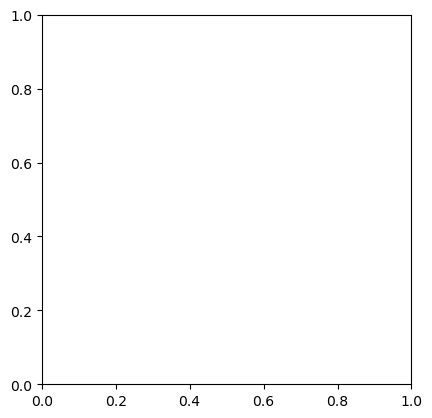

In [104]:
from matplotlib import pyplot as plt
plt.imshow(image_array[0], interpolation='nearest')
plt.show()

In [93]:
new_array = cv2.resize(image_array,(IMG_SIZE,IMG_SIZE) )

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


Importing from Keras functionality necessary to implement CNN

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras import utils
from sklearn.metrics import accuracy_score

For Now there is only 20 photos per Category, the training size will be 28 and test 12, This is for testing. After this I'll get more images to improve the CNN

In [55]:
X_train = pandasImagesDF.iloc[:-12,2].values
y_train = pandasImagesDF.iloc[:-12,1].values
X_test = pandasImagesDF.iloc[-12:,2].values
y_test = pandasImagesDF.iloc[-12:,1].values


In [56]:
X_train

array([array([255., 216., 255., ..., 159., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,  20., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 168., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,  20., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 165., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 175., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,   3., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 127., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 144., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,  15., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 234., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,  31., 255., 217.], dtype=float32),
       array([255., 216., 255., ..., 167., 255., 217.], dtype=float32),
       array([255., 216., 255., ...,  22., 255., 217.], dtype=fl

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [57]:
encoder = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)

In [58]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [59]:
X_train

array([[array([255., 216., 255., ..., 159., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ...,  20., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 168., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ...,  20., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 165., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 175., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ...,   3., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 127., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 144., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ...,  15., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 234., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ...,  31., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 167., 255., 217.], dtype=float32)],
       [array([255., 216., 255., ..., 

In [70]:
len(X_train[7][0])

6909

In [60]:
X_train = np.reshape(X_train, (X_train.shape[0], 1080,1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0], 1080,1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1],1))

ValueError: cannot reshape array of size 28 into shape (28,1080,1)

In [41]:
X_train.shape

(28, 1, 1)

Because the pixels are from 0 to 255, We have to normalize the pixels

In [28]:
X_train/=255
X_test/=255

In [29]:
model = Sequential()
model.add(Conv2D(25,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu", input_shape=(1080,1080,1)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())

model.add(Dense(100, activation="relu"))
model.add(Dense(10,activation="softmax"))

In [30]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [31]:
y_train.shape

(28, 2, 1)

In [ ]:
z =np.(X_train)

In [34]:
x_train = np.asarray(X_train)
Y_train = np.asarray(y_train)
x_test = np.asarray(X_test)
Y_test = np.asarray(y_test)

In [36]:
model.fit(x_train, Y_train, batch_size=14, epochs=10, validation_data=(x_test, Y_test))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).